# From data to functa: Your data point is a function and you can treat it like one
- ICML2022
- DeepMind

[ArXiv Link](https://arxiv.org/pdf/2201.12204.pdf)

# 论文介绍

## preliminary

设$x$为输入数据，$y'$为模型输出，则神经网络模型$M$推理过程最概括性的描述为：$y'=M(x|w)$

以图像为例，考虑高为H,宽为W的图像$x$，则$x$实际上是一个定义在2维网格$I$上的函数$f$，它可以将坐标网格参数c映射至特征空间（RGB）$\mathcal{f}$.

则有 $f_i=x_i=F(c_i)$，其中$i$为一组坐标，$x_i$, $f_i$都代表一个像素点的取值.

以下是函数$F$的一种实现方式：

In [2]:
import numpy as np

def func_f(data, h, w):
    assert h >= 0 and w >= 0
    assert data.shape[0] > h and data.shape[1] > w
    return data[h, w]

img = np.random.randn(128, 128, 3)
pixel = func_f(img, 10, 10)
print("Get x_i at (10, 10) = {}".format(pixel))

Get x_i at (10, 10) = [-0.87708813  0.58026318 -0.1591416 ]


> （点题）Your data point is a function and you can treat it like one

上面这种函数$F$的实现方式非常无聊，但它为我们提供了观察数据样本的新视角

即一个数据(data)可以被看作一个函数(functa），并且这二者可以是等价的，你可以直接把functa喂给下游模型，像把data喂给模型一样地去训练下游任务。

**那么，作为一个函数，functa不一定要定义在离散的网格空间上，也可以定义在连续的实数空间。**

这是符合直觉的，现实中图像本身就是连续的，只是因为采集原理的限制（CMOS），数字图像才必须由网格状的离散像素点组成.

<img src="https://ai-studio-static-online.cdn.bcebos.com/28422729425d48fb832ab557409f6a66c531e5faa1664f868171fcde61c0bfc2" width="50%" height="50%">

## Functa

因此，我们可以定义包含参数$\theta$的函数$f_i=F_\theta(c_i)$，并按照下式建立优化过程，即可获取与**每一个**数据(data)对应的functa，也就是Implicit Neural Representation(INR).

$\underset {\theta}{min}\mathcal{L}(F_\theta, \{c_i, f_i\}_{i\in I})=\underset {\theta}{min} \sum_{i\in I}{||F_\theta(c_i) - f_i||_2^2}$

但这样训练代价过高，一个NeRF场景样本就需要1 GPU/day 的运算量：

> Fitting INRs can be slow – e.g. fitting a single NeRF scene can take 1 GPU day.

因而我们自然地想到了Meta-Learning，建立如下形式的F函数：

$f_i=F(c_i | \theta, \phi)$

其中，$\theta$还是模型参数，而$\phi$是一个向量，通常为256维或512维。引入MAML（其实是MAML的改进版，CAVIA）的思想，进行如下优化步骤：

1. 对每个样本${x_i^{(j)}}$建立$\phi_j\leftarrow 0$
2. 在内圈调整$\phi_j$，以最小化$F(c_i | \theta, \phi)$与$x_i$的差异
3. 在外圈基于优化完成的$\phi_j$，调整模型参数$\theta$

详见原文：

![](https://ai-studio-static-online.cdn.bcebos.com/1f5fe76e78924c2eb1e3e7407fd24044f6b561e58aca44819fe5c6c765a5c584)

总的来说，这样的好处是，模型学到一个参数组合$\theta$，使得对于任意样本$x^{(j)}$，都可以让$\phi_j$在几步迭代之内快速收敛。从这里你可以看到小样本学习（FSL）、Meta-Learning和Expectation–maximization的影子

# Codes

理论部分结束 :-)

模型结构复现自官方源码，并且完成了官方模型权重的迁移。官方源码详见 https://github.com/deepmind/functa

官方写的JAX代码风格「有些」晦涩，有兴趣的同学可以试着读读看 -_-

In [3]:
import sys
sys.path.append("./work")

In [4]:
import paddle
# !pip install paddlepaddle-gpu
# !conda install cudatoolkit=10.2
paddle.get_device()
paddle.set_device("gpu:0")
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt

from model import LatentModulatedSiren # 这个就是我们的模型F_theta
from utils import get_coordinate_grid
%matplotlib inline

In [4]:
# Extract from `celeba_params_512_latents.npz`
model_cfg = {
    'out_channels': 3,
    'depth': 15,
    'latent_dim': 512,
    'latent_init_scale': 0.01,
    'layer_sizes': [],
    'meta_sgd_clip_range': [0, 1],
    'meta_sgd_init_range': [0.005, 0.1],
    'modulate_scale': False,
    'modulate_shift': True,
    'use_meta_sgd': True,
    'w0': 30,
    'width': 512}

bs = 9 # batch size
recon_shape = 64 # 重建的图像尺寸，也就是二维网格I的尺寸

In [5]:
model = LatentModulatedSiren(**model_cfg)
# 官方提供的预训练权值，迁移成的paddle权值
model.set_state_dict(paddle.load("/home/zhsyy/fyx/paddle_functa/work/assets/celeba_params_512_latents.pdparams"))
model.eval()

W0620 04:14:42.057850 52001 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 11.4, Runtime API Version: 10.2
W0620 04:14:42.065887 52001 gpu_resources.cc:91] device: 0, cuDNN Version: 7.6.
/home/zhsyy/miniconda3/envs/test/lib/python3.8/site-packages/paddle/fluid/dygraph/layers.py:1652: UserWarning: Skip loading for meta_sgd_lrs.meta_sgd_lrs. meta_sgd_lrs.meta_sgd_lrs is not found in the provided dict.
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/home/zhsyy/miniconda3/envs/test/lib/python3.8/site-packages/paddle/fluid/dygraph/layers.py:1652: UserWarning: Skip loading for latent.latent_vector. latent.latent_vector receives a shape [512], but the expected shape is [1, 512].
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))


In [6]:
# Celeba数据集，官方提供的预先拟合好的phi向量，从实践操作角度可以认为是functa
# 从概念上严格来说 （模型F, 参数theta, phi向量），才是functa。但模型F和参数theta在推理时是固定的
with open("/home/zhsyy/fyx/paddle_functa/work/assets/celeba_modulations_512_latents.pk", 'rb') as f:
    data = pk.load(f)
    train_dict = data['train']
    test_dict = data['test']

test_mods = test_dict['modulation'][bs : 2 * bs]
# test_mods = test_dict['modulation'][:bs]
print(test_mods.shape)

(9, 512)


In [7]:
# 生成网格，基于np.mesh_grid，有兴趣的同学可以读下实现
# 也可以更改recon_shape看看图像会有什么变化
recon_shape = 128 # 重建的图像尺寸，也就是二维网格I的尺寸
coords = get_coordinate_grid(recon_shape).astype("float32") # you could edit recon_shape here
coords = np.stack([coords for _ in range(bs)])
pp_out = model(paddle.to_tensor(coords), paddle.to_tensor(test_mods))

: 

: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


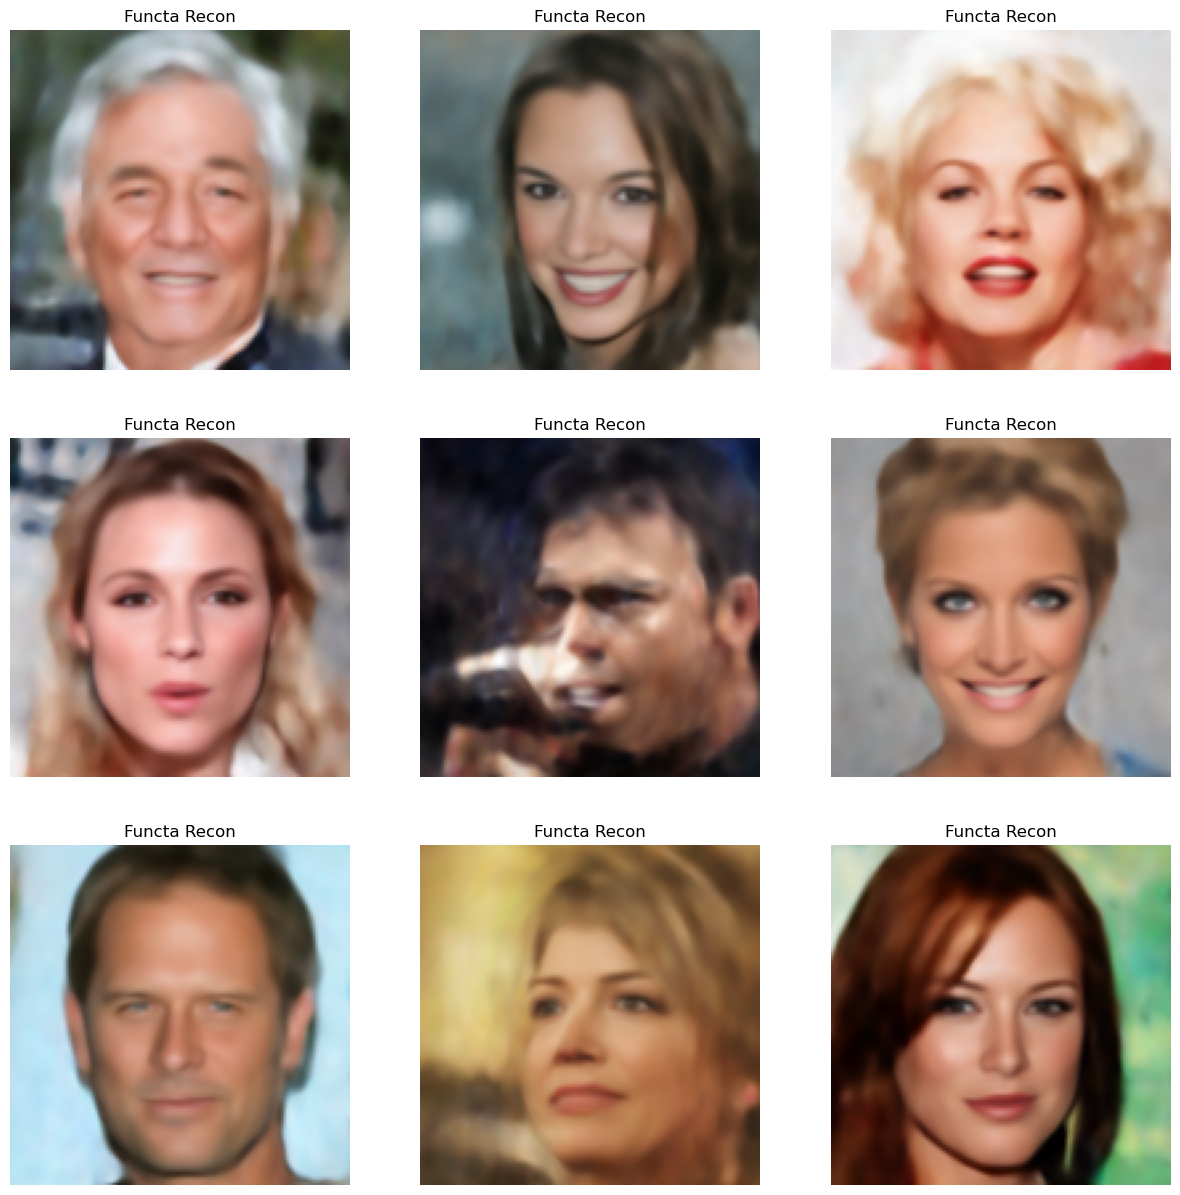

In [84]:
# 可视化，Recon = Reconstruct，重建结果
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(pp_out[i].numpy())
    plt.axis("off")
    plt.title("Functa Recon") # reconstruct from functa

## Modulation Fitting

上面的人脸图像重建结果，就是论文作者给的展示demo了，可以看出我们的模型推理过程与原作是一致的，这表明推理过程正确复现 / 移植

接下来展示对于已经训练好的 $F_\theta$，提取向量$\phi$的过程（Meta-Learning里的内圈循环）

这里我离线训练了一个Mnist Demo，RGB图像训练起来还是比较慢，例如Celeba数据集，作者报告训练了500,000个(5e5)iterations

即使Mnist Demo也训练了3 GPU / day

In [5]:
from train import inner_step # 内圈循环、外圈循环，都写在这里。有兴趣训练外圈循环的同学可以自行阅读train.py
import dataloaders.mnist as mnist # paddlevision的mnist数据集，进行/255操作，并pad 至32x32

In [6]:
model_cfg = {
    'batch_size': 4,
    'out_channels': 1, # Gray
    'depth': 15,
    'latent_dim': 512,
    'latent_init_scale': 0.01,
    'layer_sizes': [],
    'meta_sgd_clip_range': [0, 1],
    'meta_sgd_init_range': [0.005, 0.1],
    'modulate_scale': False,
    'modulate_shift': True,
    'use_meta_sgd': True,
    'w0': 30,
    'width': 512}

bs = 9
recon_shape = 64
inner_steps = 3
# inner_steps = 10
inner_lr = 1e-2 # Follow原作超参设置

In [7]:
model0 = LatentModulatedSiren(**model_cfg)
state_dict = paddle.load("./work/assets/mnist_params_512_latents_100000.pdparams")
model0.set_state_dict(state_dict)

W0620 06:02:50.464349 52231 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 11.4, Runtime API Version: 10.2
W0620 06:02:50.472419 52231 gpu_resources.cc:91] device: 0, cuDNN Version: 7.6.
/home/zhsyy/miniconda3/envs/test/lib/python3.8/site-packages/paddle/fluid/dygraph/layers.py:1652: UserWarning: Skip loading for meta_sgd_lrs.meta_sgd_lrs. meta_sgd_lrs.meta_sgd_lrs is not found in the provided dict.
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/home/zhsyy/miniconda3/envs/test/lib/python3.8/site-packages/paddle/fluid/dygraph/layers.py:1652: UserWarning: Skip loading for latent.latent_vector. latent.latent_vector receives a shape [128, 512], but the expected shape is [4, 512].
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))


In [8]:
model = model0

In [9]:
dataset = mnist.Mnist(split="test", transforms=None) # 训练集用于优化theta

shape of X: (10000, 32, 32), y: (10000,)


获取测试集的labels用于下游分类任务：

In [10]:
label_list = []
for i in range(len(dataset)):
    _, _, label, _ = dataset.__getitem__(i)
    label_list.append(label)
# label_list
with open("/home/zhsyy/fyx/paddle_functa/work/labels.txt", "w") as file:
        for item in label_list:
            file.write(str(item) + "\n")

In [11]:
criterion = paddle.nn.MSELoss('none') # 自定义逻辑，重建结果样本内mean，样本间sum
inner_optim = paddle.optimizer.SGD(inner_lr, parameters=[model.latent.latent_vector]) # 内圈优化只调整phi

In [12]:
model_cfg['batch_size']

4

In [13]:
# 取几个样本
images = []
coords = []
# for i in range(model_cfg['batch_size']):
for i in range(4): # 10000 test samples
    # i, c, _, _ = dataset.__getitem__(4650 + i)
    i, c, _, _ = dataset.__getitem__(i)
    images.append(i)
    coords.append(c)
images = paddle.to_tensor(np.stack(images))
coords = paddle.to_tensor(np.stack(coords))

model.train()
# 初始化phi_j = [0] * 512
paddle.assign(
    np.zeros(model.latent.latent_vector.shape).astype("float32"),
    model.latent.latent_vector,
)
# 迭代10iters，事实上3iters就可以取得不错的效果
for j in range(3):
    inner_loss = inner_step(images, coords, model, inner_optim, criterion)
    psnr = -10 * np.log10(inner_loss / model_cfg['batch_size'])
    print("Inner loss {:.6f}, psnr {:.6f}".format(inner_loss[0], psnr[0]))

modulate = model.latent.latent_vector.detach() # detach

Inner loss 0.631485, psnr 8.016969
Inner loss 0.113098, psnr 15.486070
Inner loss 0.042423, psnr 19.744619


In [14]:
modulate

Tensor(shape=[4, 512], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[-0.00447626, -0.00043435,  0.00273451, ..., -0.00407475,
          0.00024847, -0.00059291],
        [-0.00226799, -0.00068785, -0.00095908, ..., -0.00205405,
         -0.00285097, -0.00530885],
        [-0.00167416, -0.00037255,  0.00196673, ..., -0.00472802,
         -0.00029339, -0.00068117],
        [-0.00177774,  0.00178311, -0.00254961, ..., -0.00071379,
         -0.00072420, -0.00063147]])

In [15]:
# 取几个样本
images = []
coords = []
# for i in range(model_cfg['batch_size']):
for i in range(4): # 10000 test samples
    # i, c, _, _ = dataset.__getitem__(4650 + i)
    i, c, _, _ = dataset.__getitem__(4 + i)
    images.append(i)
    coords.append(c)
images = paddle.to_tensor(np.stack(images))
coords = paddle.to_tensor(np.stack(coords))

model.train()
# 初始化phi_j = [0] * 512
paddle.assign(
    np.zeros(model.latent.latent_vector.shape).astype("float32"),
    model.latent.latent_vector,
)
# 迭代10iters，事实上3iters就可以取得不错的效果
for j in range(3):
    inner_loss = inner_step(images, coords, model, inner_optim, criterion)
    psnr = -10 * np.log10(inner_loss / model_cfg['batch_size'])
    print("Inner loss {:.6f}, psnr {:.6f}".format(inner_loss[0], psnr[0]))

modulate = model.latent.latent_vector.detach() # detach

Inner loss 0.706680, psnr 7.528371
Inner loss 0.140107, psnr 14.555993
Inner loss 0.046728, psnr 19.324800


In [55]:
modulate

Tensor(shape=[4, 512], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[-0.00354941,  0.00211269, -0.00036395, ..., -0.00525460,
          0.00124245,  0.00165323],
        [-0.00080859, -0.00110582,  0.00305309, ..., -0.00447421,
         -0.00044205, -0.00091843],
        [-0.00302275,  0.00015383, -0.00088166, ..., -0.00467193,
          0.00141408,  0.00024185],
        [ 0.00197069, -0.00029518, -0.00174940, ..., -0.00472361,
         -0.00144437, -0.00239845]])

In [ ]:
images.shape

[4, 32, 32, 1]

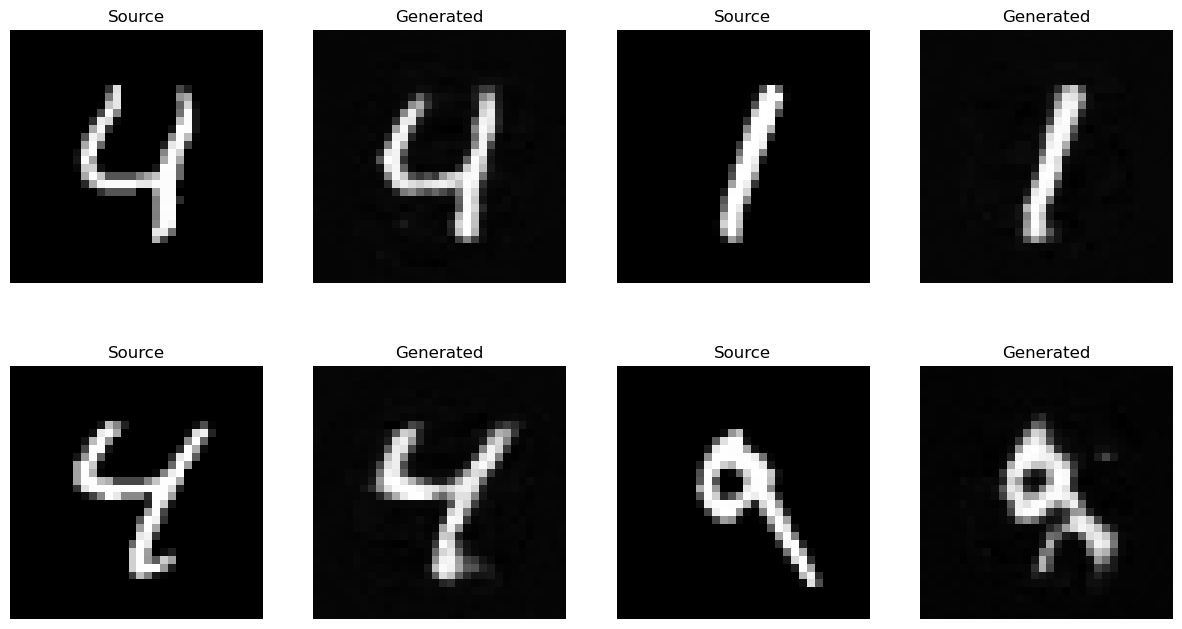

In [16]:
model.eval()
pp_out = model(coords, modulate) # 推理
plt.figure(figsize=(15, 8))

for i in range(model_cfg['batch_size']):
    plt.subplot(2, model_cfg['batch_size'], i * 2 + 1)
    plt.imshow(images[i, ..., 0].numpy(), cmap='gray')
    plt.axis("off")
    plt.title("Source")

    plt.subplot(2, model_cfg['batch_size'], i * 2 + 2)
    plt.imshow(pp_out[i, ..., 0].numpy(), cmap='gray')
    plt.axis("off")
    plt.title("Generated")

In [18]:
# 取几个样本
image_list = []
coords_list = []
# for i in range(model_cfg['batch_size']):
for k in range(2500): # 10000 / model_cfg['batch_size'] = 2500
    images = []
    coords = []
    for i in range(model_cfg['batch_size']): # 10000 test samples
        # i, c, _, _ = dataset.__getitem__(4650 + i)
        i, c, _, _ = dataset.__getitem__(k * 4 + i)
        images.append(i)
        coords.append(c)
    images = paddle.to_tensor(np.stack(images))
    coords = paddle.to_tensor(np.stack(coords))
    image_list.append(images)
    coords_list.append(coords)

In [57]:
inner_loss_list = []
psnr_list = []
modulate_batch_list = []
modulate_list = []
pp_out_list = []

In [58]:
# 迭代3iters就可以取得不错的效果
for k in range(10):
    model = LatentModulatedSiren(**model_cfg)
    model.set_state_dict(state_dict)

    criterion = paddle.nn.MSELoss('none') # 自定义逻辑，重建结果样本内mean，样本间sum
    inner_optim = paddle.optimizer.SGD(inner_lr, parameters=[model.latent.latent_vector]) # 内圈优化只调整phi
    
    # 初始化phi_j = [0] * 512
    paddle.assign(
        np.zeros(model.latent.latent_vector.shape).astype("float32"),
        model.latent.latent_vector,
    )
    model.train()

    for j in range(inner_steps):
        inner_loss = inner_step(image_list[k], coords_list[k], model, inner_optim, criterion)
        psnr = -10 * np.log10(inner_loss / model_cfg['batch_size'])
        # print("Inner loss {:.6f}, psnr {:.6f}".format(inner_loss[0], psnr[0]))
    inner_loss_list.append(inner_loss[0])
    psnr_list.append(psnr[0])
    modulate = model.latent.latent_vector.detach() # detach
    modulate_batch_list.append(modulate)
    for bs_i in range(model_cfg['batch_size']):
        modulate_list.append(modulate[bs_i])

    model.eval()
    pp_out = model(coords_list[k], modulate_batch_list[k]) # 推理
    pp_out_list.append(pp_out)

/home/zhsyy/miniconda3/envs/test/lib/python3.8/site-packages/paddle/fluid/dygraph/layers.py:1652: UserWarning: Skip loading for meta_sgd_lrs.meta_sgd_lrs. meta_sgd_lrs.meta_sgd_lrs is not found in the provided dict.
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/home/zhsyy/miniconda3/envs/test/lib/python3.8/site-packages/paddle/fluid/dygraph/layers.py:1652: UserWarning: Skip loading for latent.latent_vector. latent.latent_vector receives a shape [128, 512], but the expected shape is [4, 512].
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))


In [19]:
inner_loss_list = []
psnr_list = []
modulate_batch_list = []
modulate_list = []
pp_out_list = []

# 迭代3iters就可以取得不错的效果
for k in range(5):
    model = LatentModulatedSiren(**model_cfg)
    model.set_state_dict(state_dict)

    criterion = paddle.nn.MSELoss('none') # 自定义逻辑，重建结果样本内mean，样本间sum
    inner_optim = paddle.optimizer.SGD(inner_lr, parameters=[model.latent.latent_vector]) # 内圈优化只调整phi
    
    # 初始化phi_j = [0] * 512
    paddle.assign(
        np.zeros(model.latent.latent_vector.shape).astype("float32"),
        model.latent.latent_vector,
    )
    model.train()

    for j in range(inner_steps):
        inner_loss = inner_step(image_list[k], coords_list[k], model, inner_optim, criterion)
        psnr = -10 * np.log10(inner_loss / model_cfg['batch_size'])
        # print("Inner loss {:.6f}, psnr {:.6f}".format(inner_loss[0], psnr[0]))
    inner_loss_list.append(inner_loss[0])
    psnr_list.append(psnr[0])
    modulate = model.latent.latent_vector.detach() # detach
    modulate_batch_list.append(modulate)
    for bs_i in range(model_cfg['batch_size']):
        modulate_list.append(modulate[bs_i])

    model.eval()
    pp_out = model(coords_list[k], modulate_batch_list[k]) # 推理
    pp_out_list.append(pp_out)

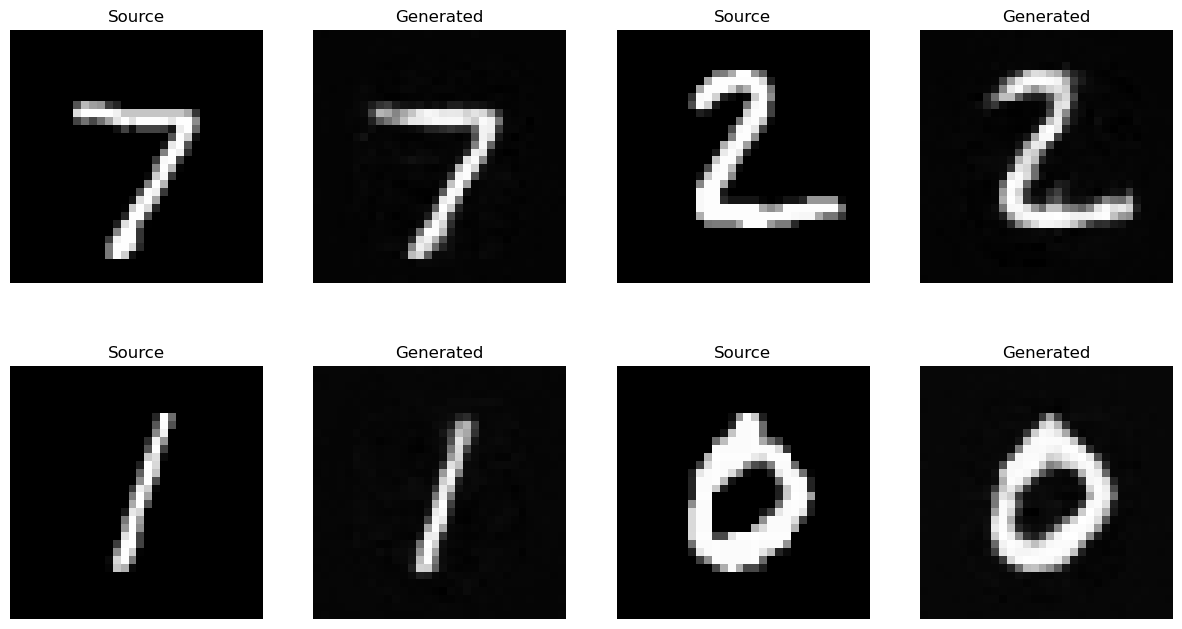

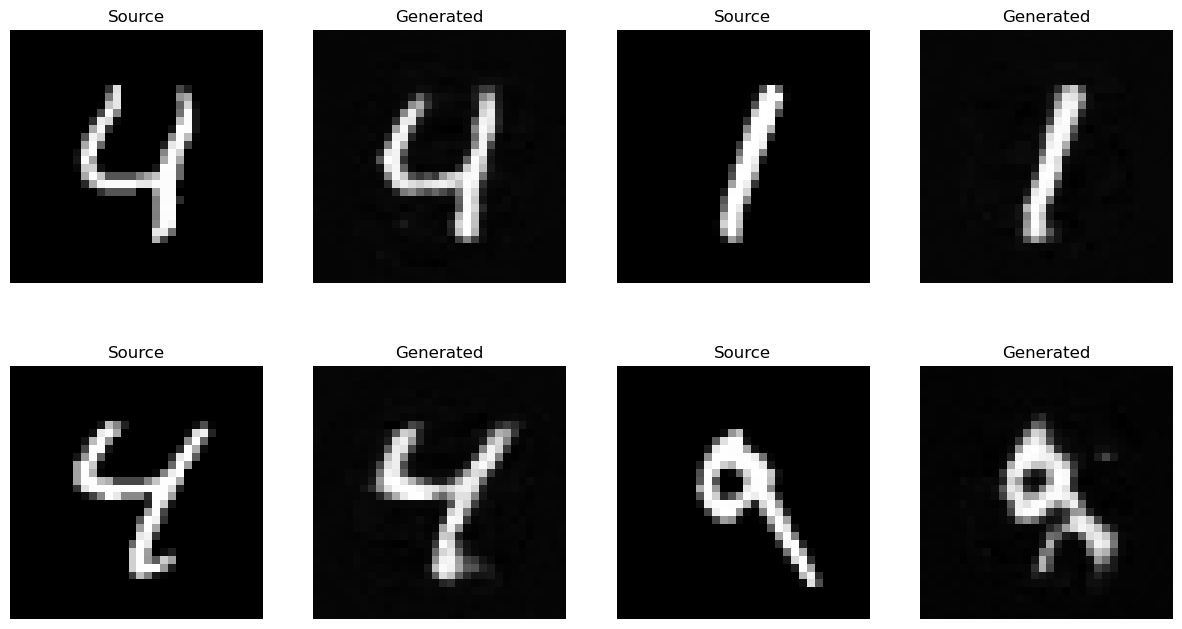

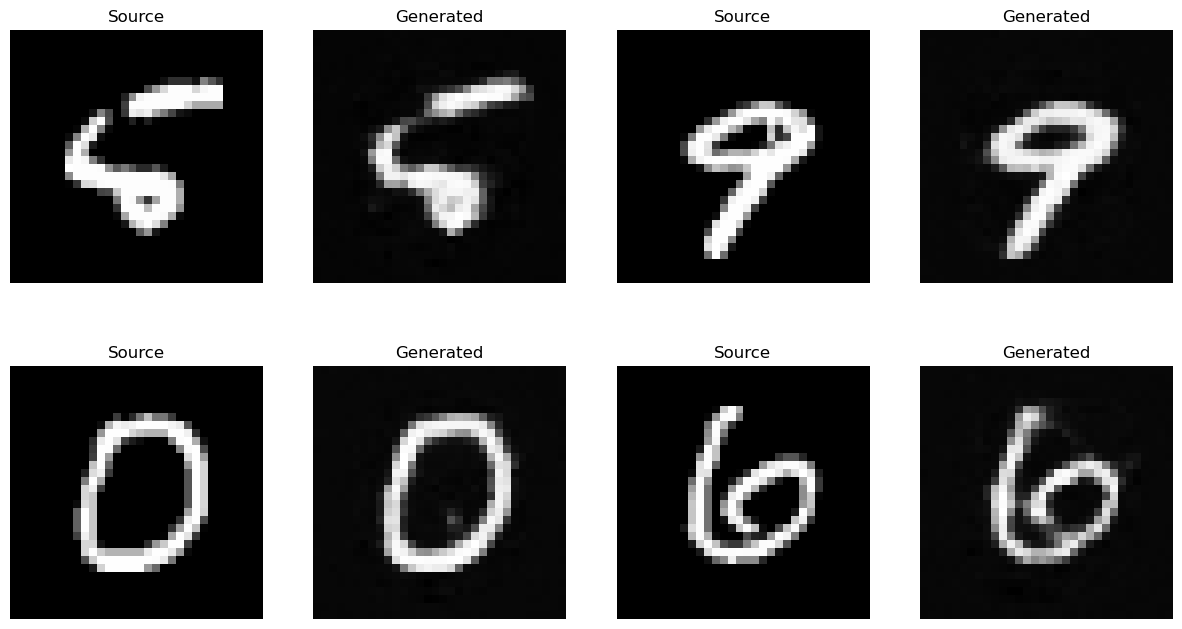

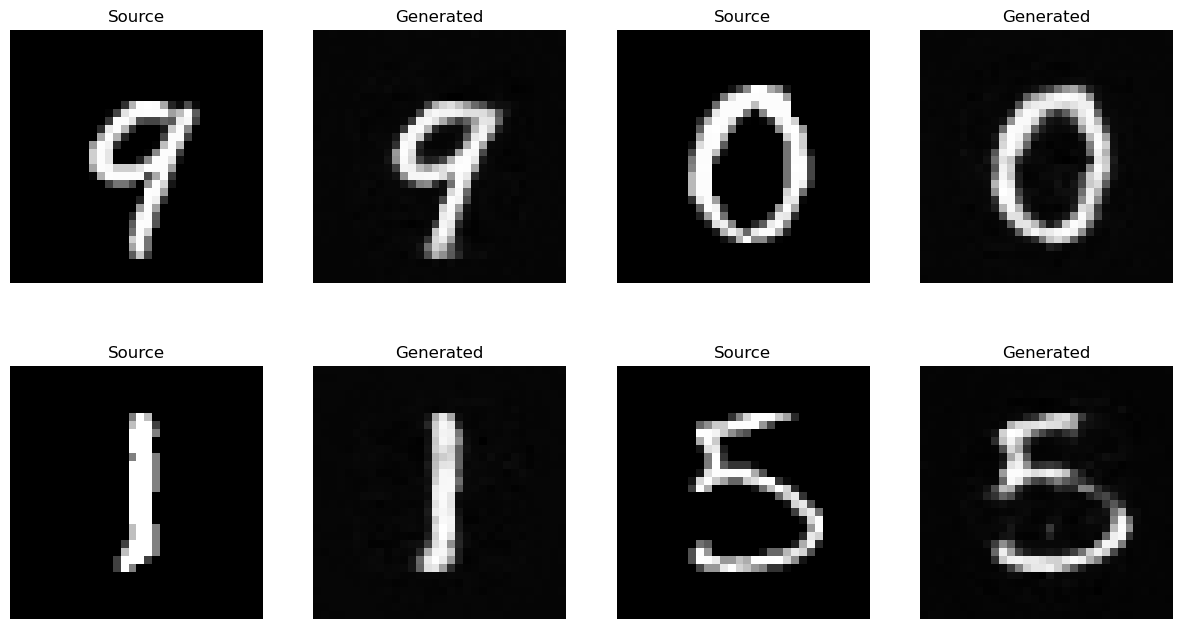

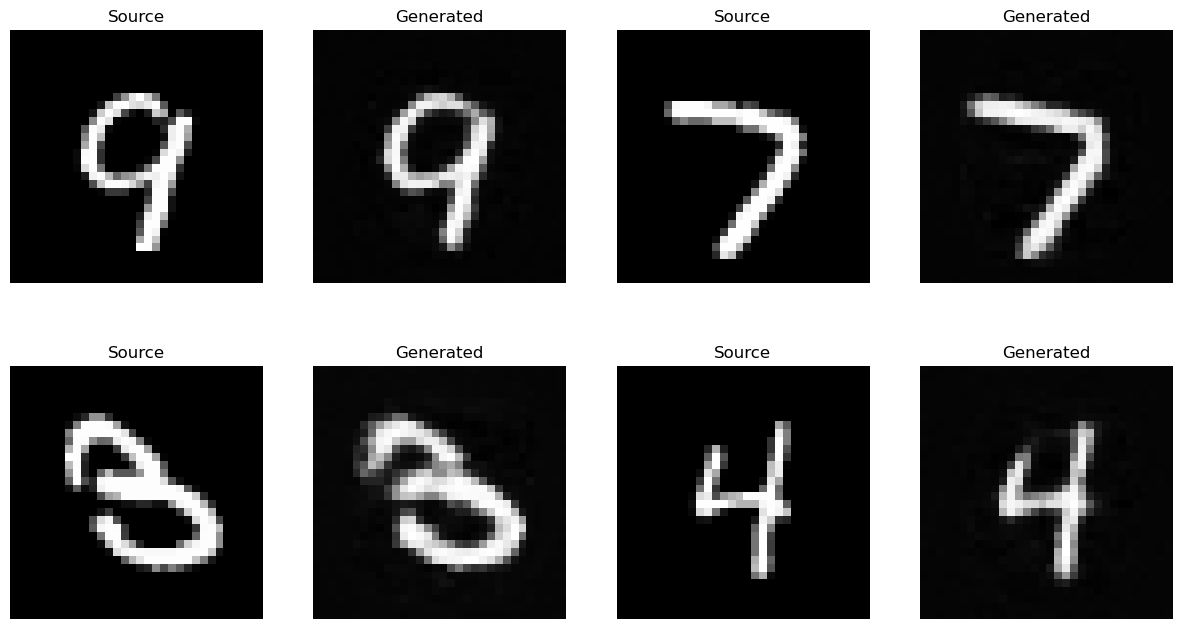

In [21]:
for k in range(5):
    plt.figure(figsize=(15, 8))
    pp_out = pp_out_list[k]
    for i in range(model_cfg['batch_size']):
        plt.subplot(2, model_cfg['batch_size'], i * 2 + 1)
        plt.imshow(image_list[k][i, ..., 0].numpy(), cmap='gray')
        plt.axis("off")
        plt.title("Source")

        plt.subplot(2, model_cfg['batch_size'], i * 2 + 2)
        plt.imshow(pp_out[i, ..., 0].numpy(), cmap='gray')
        plt.axis("off")
        plt.title("Generated")

In [ ]:
len(modulate_list)

In [ ]:
psnr_list

In [ ]:
inner_loss_list

In [ ]:
model.eval()
pp_out = model(coords_list[1], modulate_batch_list[1]) # 推理
# pp_out = model(coords, modulate) # 推理

NameError: name 'image_list' is not defined

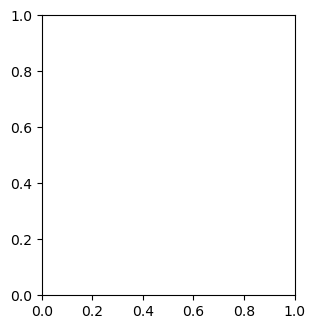

In [45]:
plt.figure(figsize=(15, 8))

for i in range(model_cfg['batch_size']):
    plt.subplot(2, model_cfg['batch_size'], i * 2 + 1)
    plt.imshow(image_list[1][i, ..., 0].numpy(), cmap='gray')
    plt.axis("off")
    plt.title("Source")

    plt.subplot(2, model_cfg['batch_size'], i * 2 + 2)
    plt.imshow(pp_out[i, ..., 0].numpy(), cmap='gray')
    plt.axis("off")
    plt.title("Generated")

## 总结

从学术品味的角度看，Functa一文无疑是一篇很"DeepMind式"的文章。INR不是新概念，但Functa一文首次证明INR可以被用于广泛的任务中

##### 优点

- 将图像数据从离散网格转为连续表征，更接近数字图像所表达的自然界的连续信号。甚至可以用于超分等领域
- 数据压缩方面，一幅1024个像素点(32x32=1024）的图像，可以存储为512维向量（甚至更低的维度）
- 提供了观察数据新的统一视角，不同分辨率、不同模态、甚至不同维度的数据，可以由一组相同长度的functa来表达

##### 缺陷

- 拟合还是比较慢，对于工程上像是用算力换存储空间，未必合算
- 对于精细结构（局部特征）拟合能力有限，似乎functa更倾向于捕捉全局特征，这可能与MSE这种优化目标有关

##### 本项目Todo

- 复现原作使用的MetaSGD（本项目目前仅使用了Vanilla SGD）
- 测试基于functa的下游任务性能. i.e, 对所有mnist数据提取functa，训练一个MLP，观察其10分类acc